In [1]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm
from pyro.optim import Adam

In [2]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import well_log_analysis.dataset
import matplotlib.pyplot as plt

import well_log_analysis.models.mlp as mlp

In [3]:
def train_test(train_wells, test_well):
    scaler = RobustScaler()
    train_dataset = well_log_analysis.dataset.WellDataset(train_wells[0], 
                                    ['GR', 'DEN', 'RT', 'DTCO', 'DTSM'], 
                                    ['GR', 'DEN', 'RT', 'DTCO', 'DTSM'], 
                                    sequence_length=1)
    
    for i in range(1, len(train_wells)):
        train_dataset += well_log_analysis.dataset.WellDataset(train_wells[i], 
                                        ['GR', 'DEN', 'RT', 'DTCO', 'DTSM'], 
                                        ['GR', 'DEN', 'RT', 'DTCO', 'DTSM'], 
                                        sequence_length=1)
    

    data = np.concatenate([train_dataset[i] for i in range(len(train_dataset))], 0)
    scaler.fit(data)
    data = scaler.transform(data)
    x, y = data[:, :3], data[:, 3:]
    test_dataset = well_log_analysis.dataset.WellDataset(test_well,
                                ['GR', 'DEN', 'RT', 'DTCO', 'DTSM'], 
                                ['GR', 'DEN', 'RT', 'DTCO', 'DTSM'], 
                                sequence_length=1)
    
   
    test_data = np.concatenate([test_dataset[i] for i in range(len(test_dataset))], 0)
    test_data = scaler.transform(test_data)
    
    x_test, y_test = test_data[:, :3], test_data[:, 3:]
    x, y = torch.from_numpy(x).float(), torch.from_numpy(y).float()
    x_test, y_test = torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float()
    return x, y, x_test, y_test

In [4]:
dataset_paths = ['data/dataset1/J10025.las', 'data/dataset1/J10035.las', 'data/dataset1/J10039.las', 'data/dataset1/J10051.las', 'data/dataset1/J10038.las']

x, y, x_test, y_test = train_test(dataset_paths[:-1], dataset_paths[-1])

In [7]:
class BayesianLinear(PyroModule):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.bias = PyroSample(
            prior=dist.Normal(0, 1).expand([out_size]).to_event(1))
        self.weight = PyroSample(
            prior=dist.Normal(0, 1).expand([in_size, out_size]).to_event(2))

    def forward(self, input):
        return self.bias + input @ self.weight  # this line samples bias and weight
    
    
class Model(PyroModule):
    def __init__(self, in_size=3, hidden_size1 = 64, hidden_size2 = 64, out_size=2):
        super().__init__()
        self.fc1 = BayesianLinear(in_size, hidden_size1)
        self.fc2 = BayesianLinear(hidden_size1, hidden_size2)
        self.fc3 = BayesianLinear(hidden_size2, out_size)
        self.relu = nn.ReLU()
        self.obs_scale = PyroSample(dist.Uniform(0, 15))
        
    def forward(self, x, y=None):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        obs_loc = x
        obs_scale = self.obs_scale    # this samples self.obs_scale
        with pyro.plate("instances", len(x)):
            return pyro.sample("obs", dist.Normal(obs_loc, obs_scale).to_event(1), obs=y)

In [26]:
pyro.clear_param_store()
pyro.set_rng_seed(1)
model = Model()
guide = AutoDiagonalNormal(model)
svi = SVI(model, guide, Adam({"lr": 0.01}), Trace_ELBO())

for i in range(5_000):
    loss = svi.step(x, y) / y.numel()
    if i % 100 == 0:
        print("step {} loss = {:0.4g}".format(i, loss))

step 0 loss = 3.39
step 100 loss = 2.698
step 200 loss = 1.607
step 300 loss = 0.7555
step 400 loss = 0.3167
step 500 loss = 0.2878
step 600 loss = 0.3238
step 700 loss = 0.2677
step 800 loss = 0.2314
step 900 loss = 0.2745
step 1000 loss = 0.2137
step 1100 loss = 0.2246
step 1200 loss = 0.1843
step 1300 loss = 0.1947
step 1400 loss = 0.1752
step 1500 loss = 0.1766
step 1600 loss = 0.1721
step 1700 loss = 0.1769
step 1800 loss = 0.1596
step 1900 loss = 0.1557
step 2000 loss = 0.1486
step 2100 loss = 0.1501
step 2200 loss = 0.155
step 2300 loss = 0.1405
step 2400 loss = 0.1473
step 2500 loss = 0.131
step 2600 loss = 0.1898
step 2700 loss = 0.1307
step 2800 loss = 0.1328
step 2900 loss = 0.1277
step 3000 loss = 0.1189
step 3100 loss = 0.1201
step 3200 loss = 0.124
step 3300 loss = 0.1259
step 3400 loss = 0.1293
step 3500 loss = 0.1125
step 3600 loss = 0.1552
step 3700 loss = 0.1268
step 3800 loss = 0.1107
step 3900 loss = 0.1045
step 4000 loss = 0.1066
step 4100 loss = 0.1094
step 4200 l

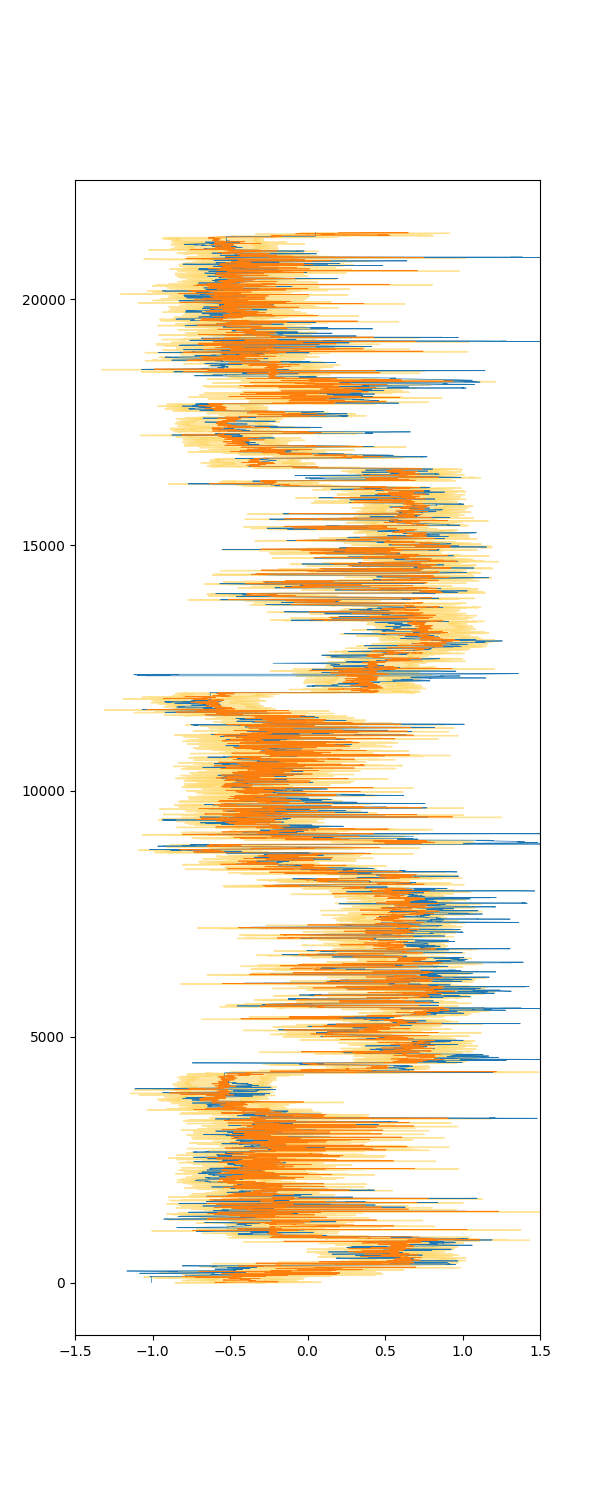

In [25]:
import matplotlib.pyplot as plt
%matplotlib ipympl
x_cur, y_cur = x, y
predictive = Predictive(model, guide=guide, num_samples=500)
preds = predictive(x_cur)

y_pred = preds['obs'].detach().numpy().mean(axis=0)[:, 0]
y_std = preds['obs'].detach().numpy().std(axis=0)[:, 0]

fig, ax = plt.subplots(figsize=(6, 15))
ax.plot(y_cur[:, 0], range(len(y_cur[:, 0])), linewidth=0.5)
ax.plot(y_pred, range(len(y_cur[:, 0])), linewidth=0.5)
ax.fill_betweenx(range(len(y_cur[:, 0])), y_pred - y_std, y_pred + y_std,
                alpha=0.5, color='#ffcd3c')
plt.xlim([-1.5, 1.5])
plt.show()


In [24]:
print(np.std(y_std))

0.010229238
